# Exploration Notebook for Louvain (UCI-ID 186, Wine Quality)


## Imports

In [11]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
import umap.plot
from ucimlrepo import fetch_ucirepo

In [13]:
import sys

sys.path.append("../")
import visualization
import processing
from embedding_obj import EmbeddingObj

## Data Preparation

In [14]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

target_feature = "pH"
labels = pd.Categorical(y["quality"]).codes

X.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_13004\187994372.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


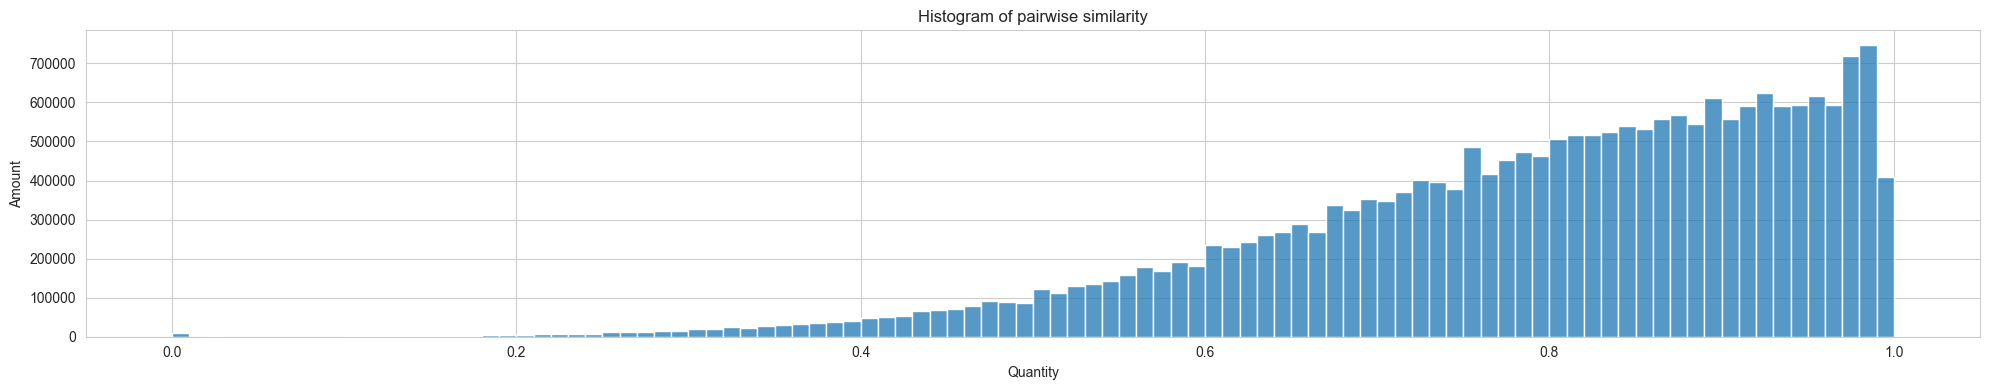

In [15]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])
i_upper = np.triu_indices_from(connectivity_pairwise, k=1)
connectivity_pairwise = connectivity_pairwise[i_upper]

fig, ax = plt.subplots(figsize=(20, 4))
sb.histplot(connectivity_pairwise.flatten(), bins=100, ax=ax)
ax.set_title("Histogram of pairwise similarity")
ax.set_xlabel("Quantity")
ax.set_ylabel("Amount")

fig.tight_layout()
fig.show()

## Compute initial UMAP-Embedding & Louvain Partition

In [16]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature], n_neighbors=5)

knn_list = [
    EmbeddingObj(graph=graph_umap_knn,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_umap_knn,
                 title="UMAP-Positions with UMAP-kNN"),
    EmbeddingObj(graph=graph_knn_feat,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_knn_feat,
                 title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'")
]

for embedding_obj in knn_list:
    embedding_obj.com_partition = community_louvain.best_partition(
        embedding_obj.sim_graph, random_state=0)

    embedding_obj.labels = embedding_obj.com_partition

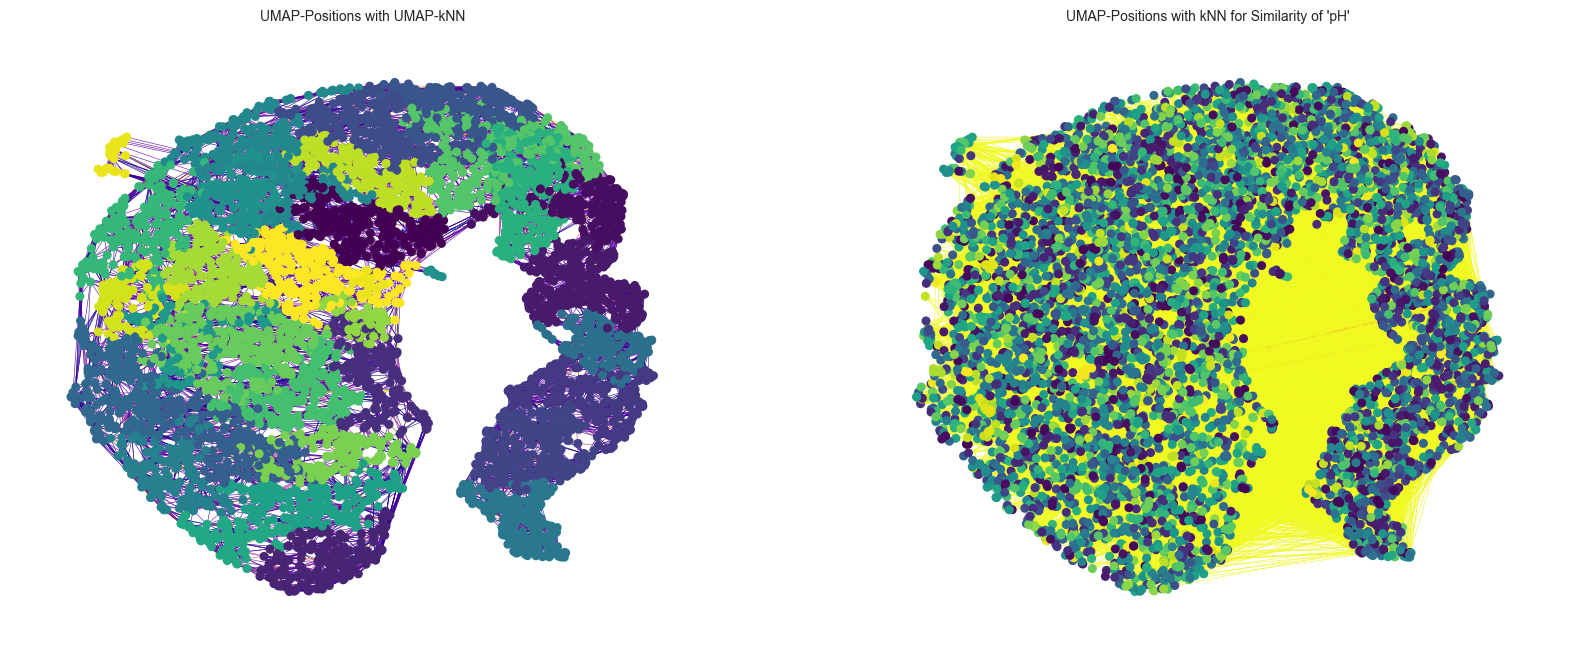

In [18]:
visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 8),
                             cmap='viridis',
                             show_cbar=False)

## Visualize embeddings

In [19]:
pairwise_distances = processing.compute_pairwise_dist(X, [target_feature])

connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)
for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = pairwise_distances[u][v]

In [20]:
iterations = [1, 2, 5, 10]
method = "fr"

### 2.1 No MST, no threshold

In [21]:
embeddings, partition_dict = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    iterations=iterations, method=method)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  2
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


In [22]:
# partition_values = embeddings[0].labels
partition_values = set(partition_dict.values())

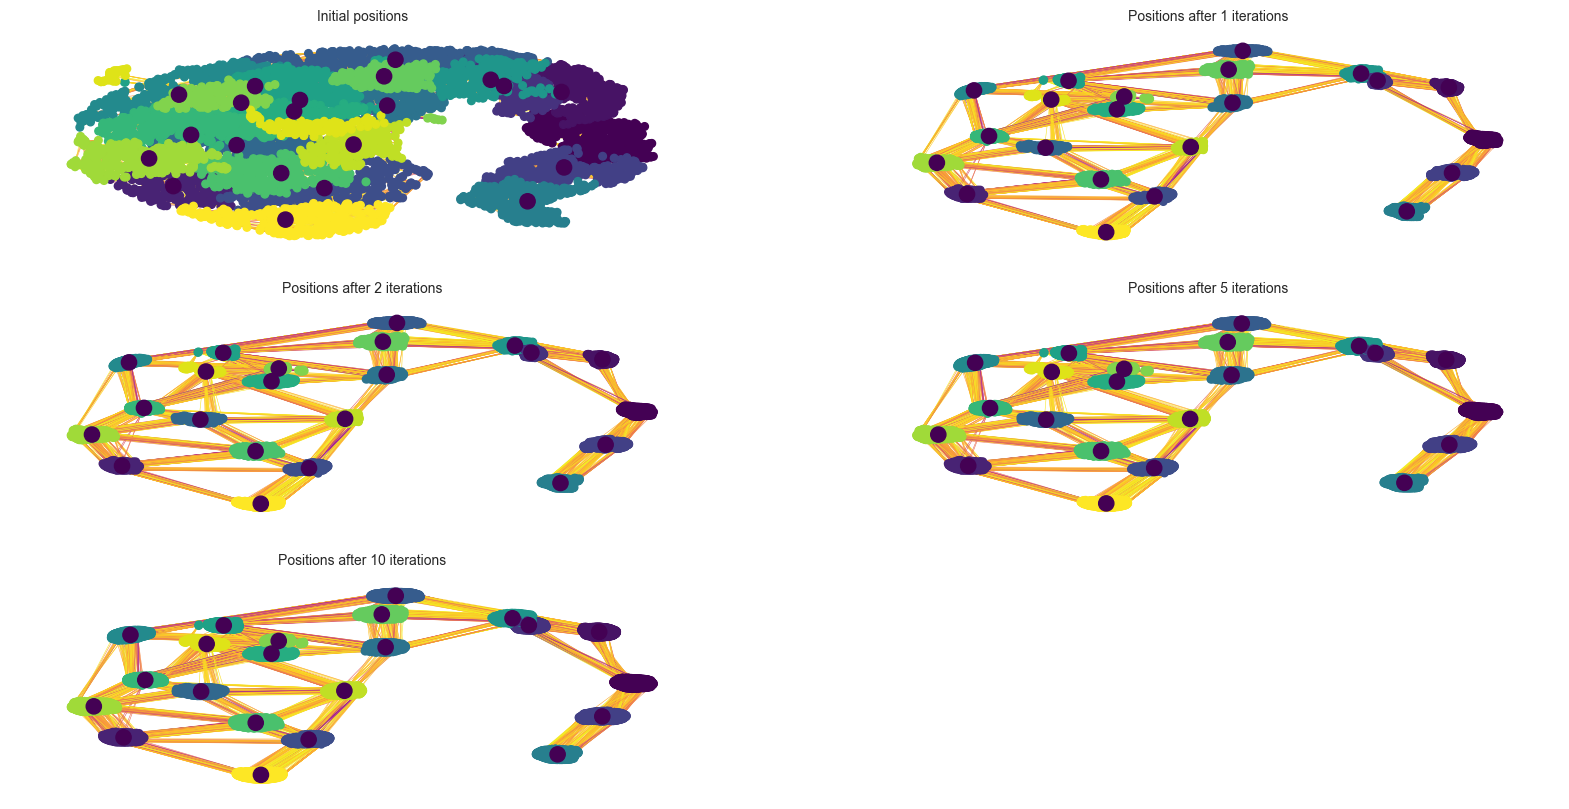

In [23]:
visualization.display_graphs(embeddings,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             # cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

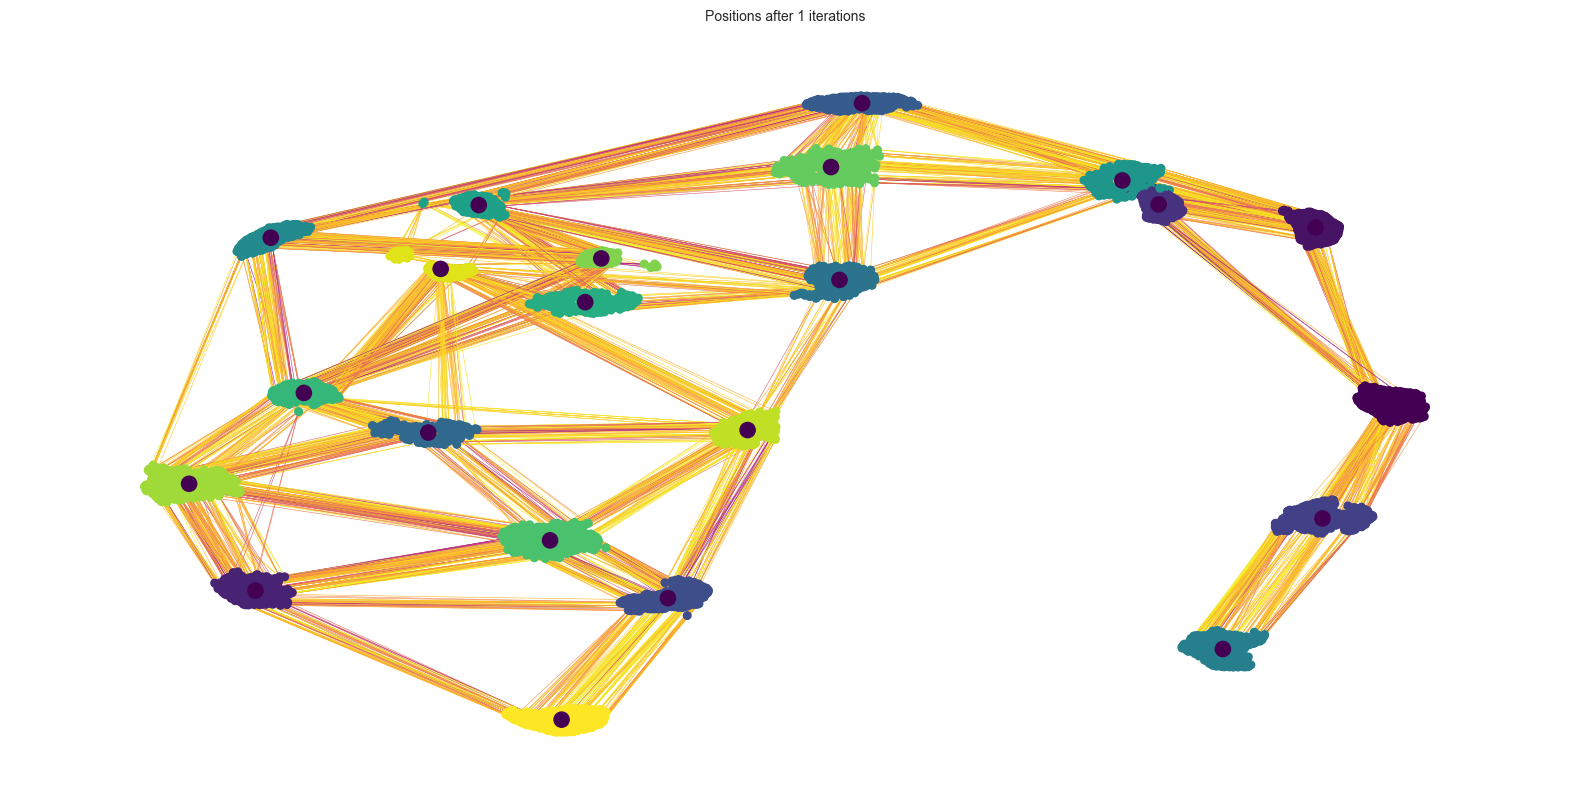

In [42]:
visualization.display_graphs([embeddings[1]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True
                             )

### 2.2 No MST, threshold at 0.1

In [25]:
embeddings_threshold, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    iterations=iterations,
    method=method,
    threshold=0.1)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  2
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


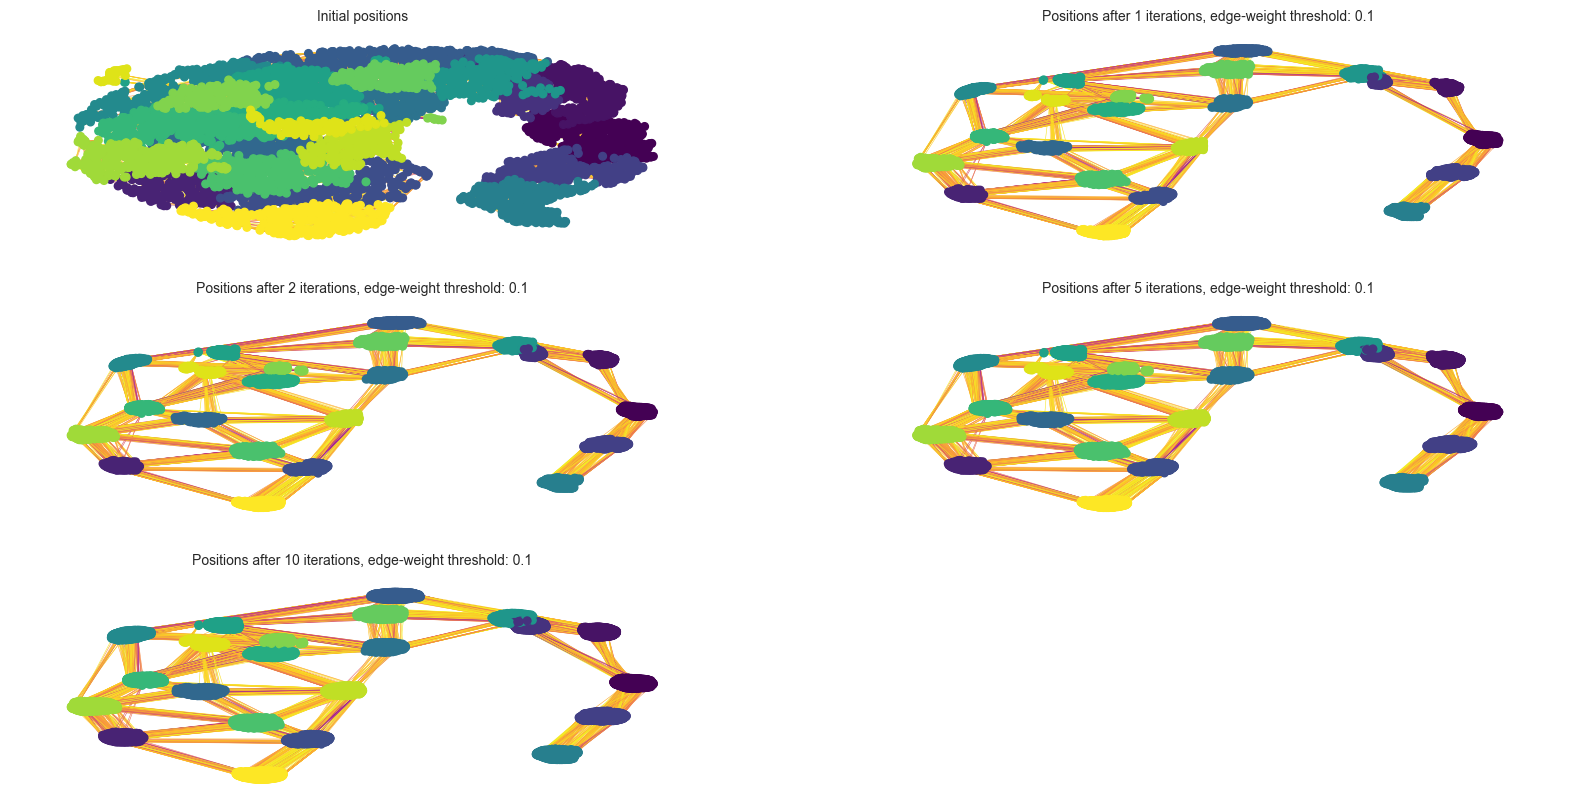

In [26]:
visualization.display_graphs(embeddings_threshold,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

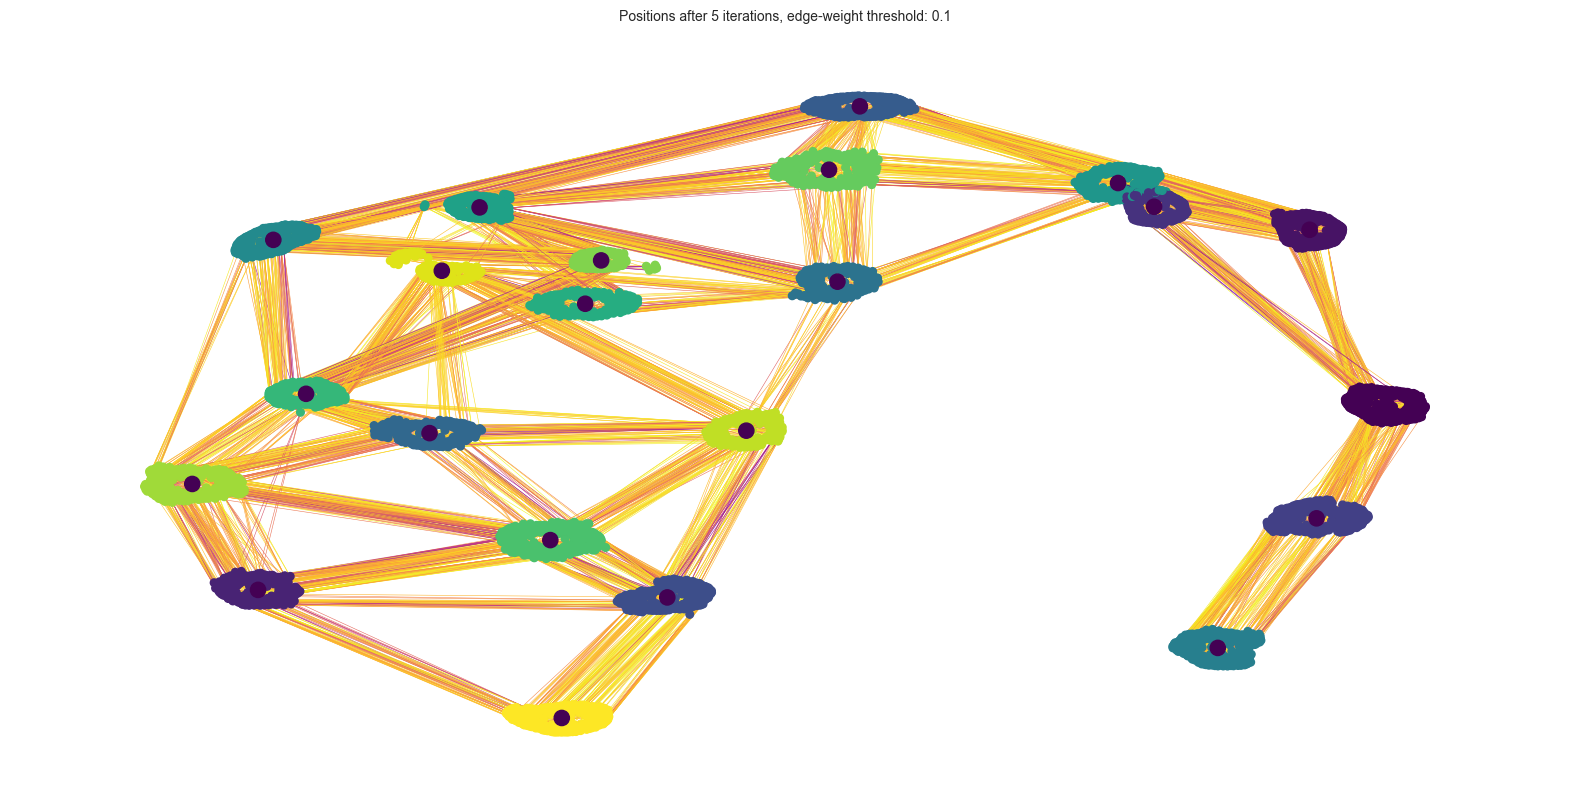

In [27]:
visualization.display_graphs([embeddings_threshold[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.3 MST, no threshold

In [28]:
embeddings_mst, _ = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                            umap_embedding,
                                                            iterations=iterations,
                                                            method=method,
                                                            mst=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  2
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


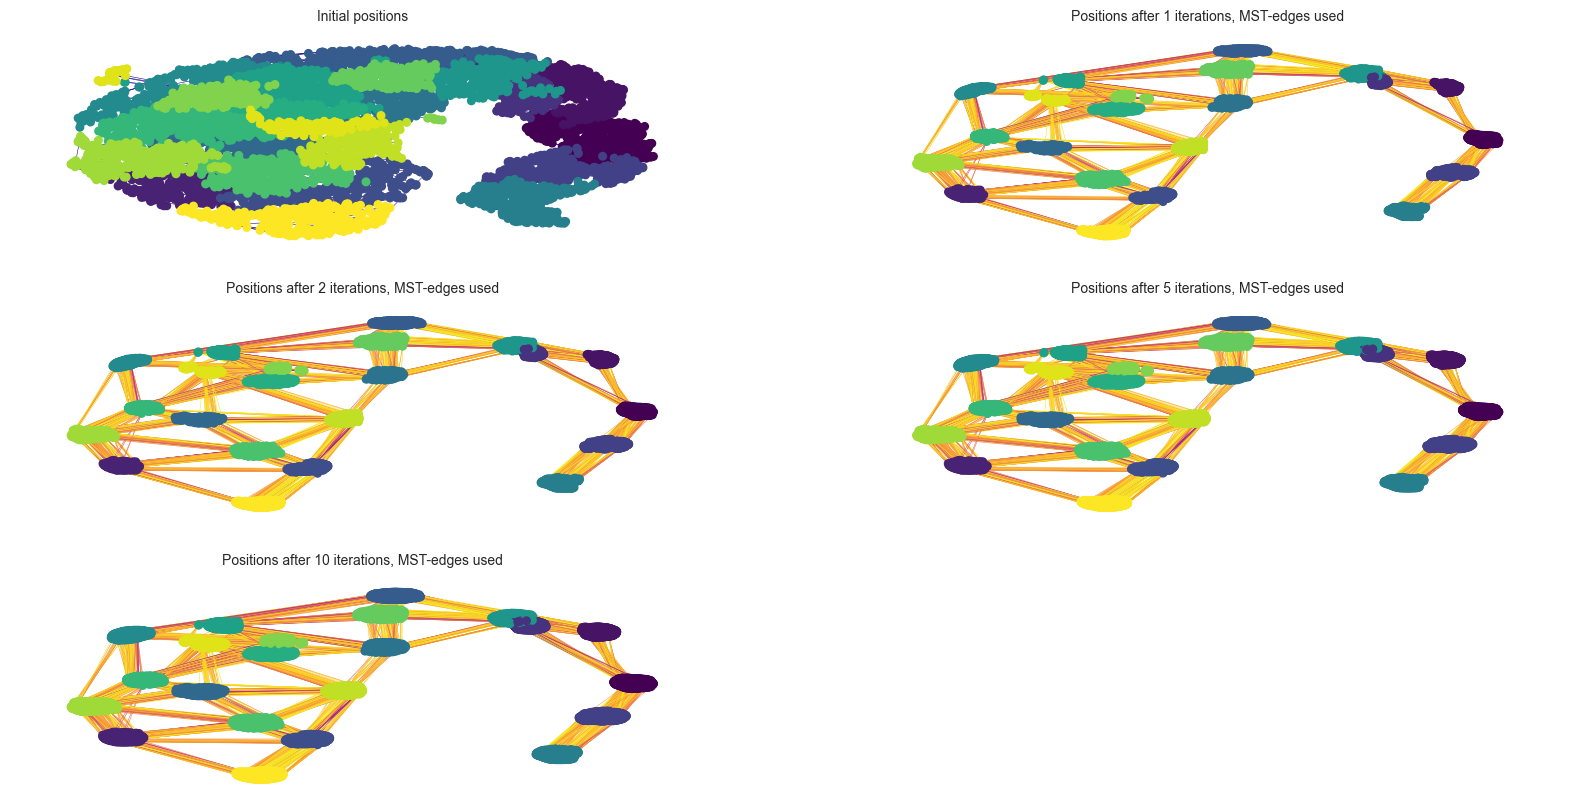

In [29]:
visualization.display_graphs(embeddings_mst,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

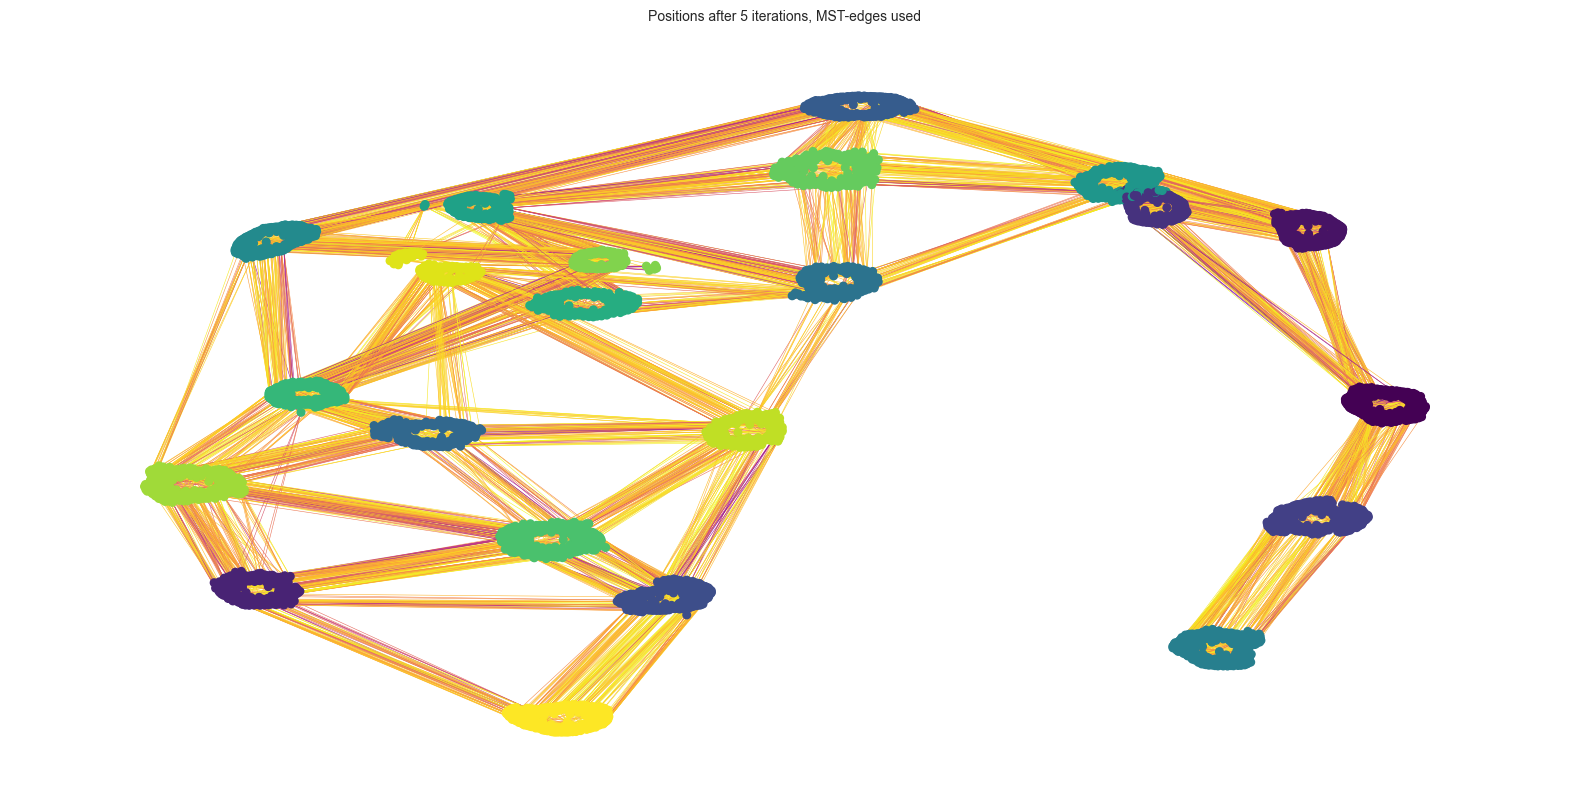

In [30]:
visualization.display_graphs([embeddings_mst[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

### 2.4 No MST, use boundary-edges

In [31]:
embeddings_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    iterations=iterations,
    method=method,
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  2
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


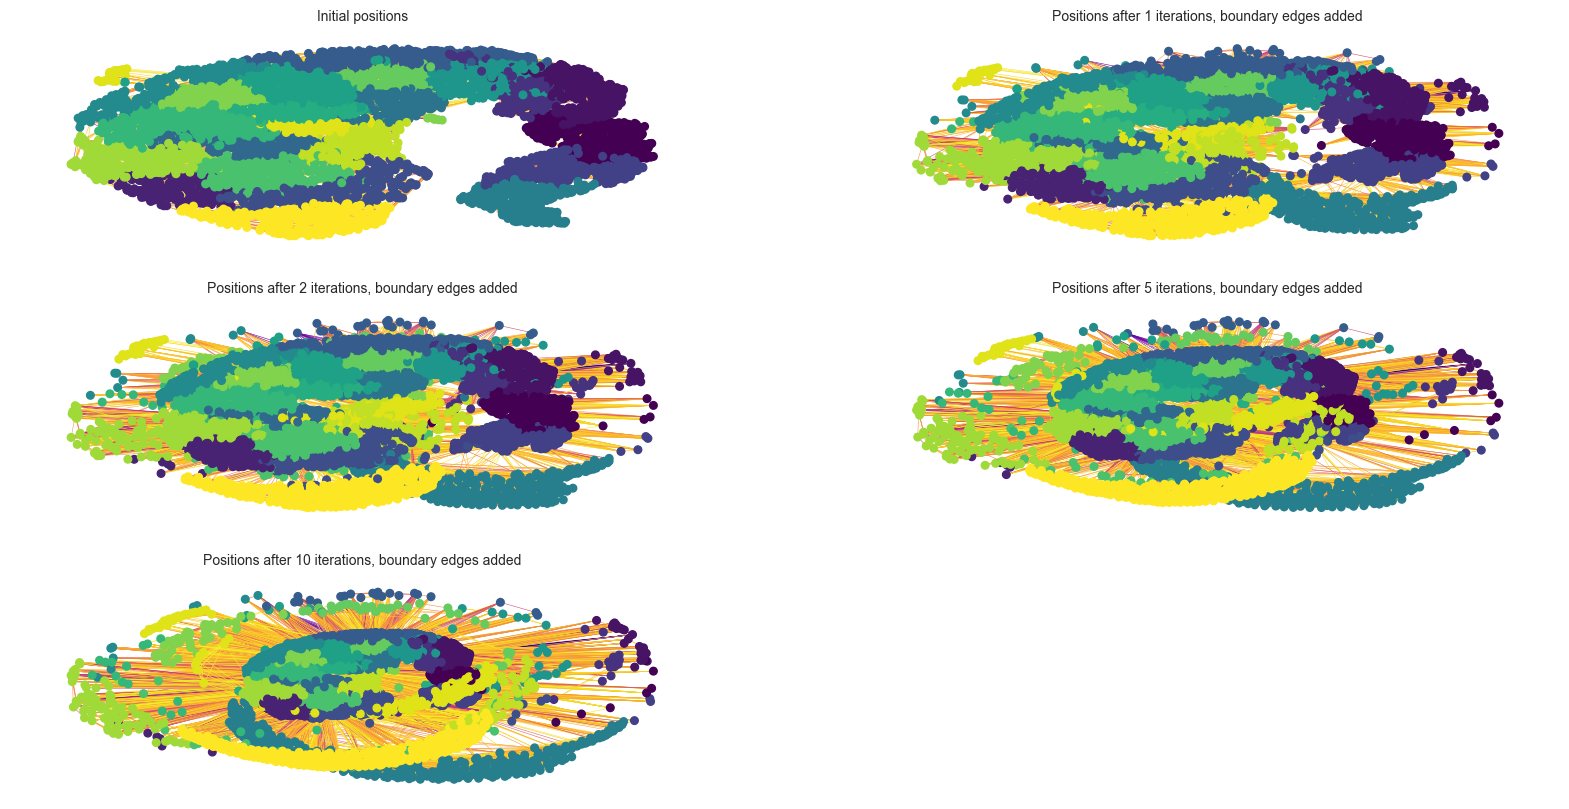

In [32]:
visualization.display_graphs(embeddings_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

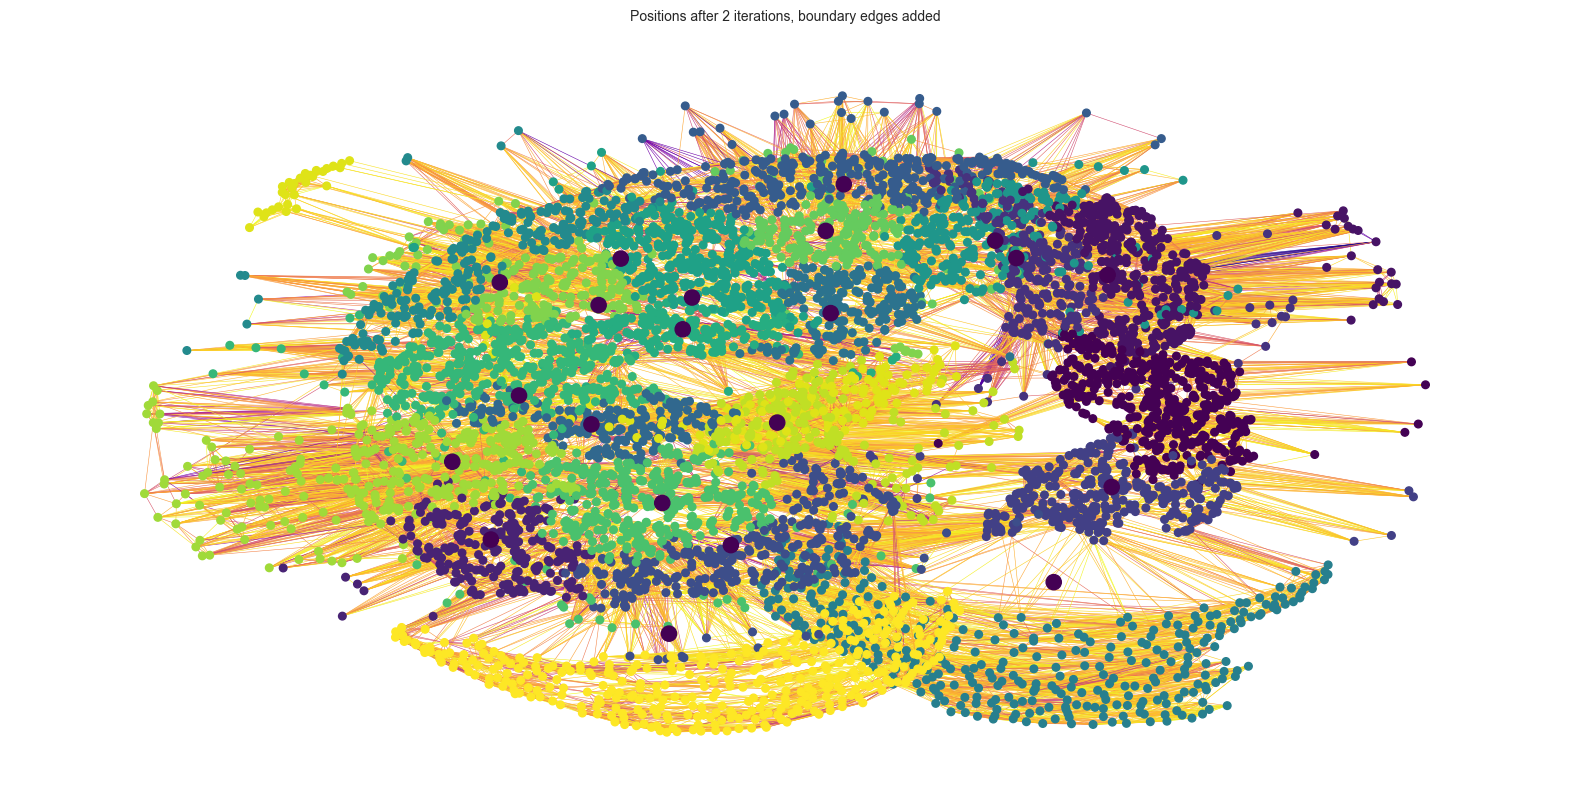

In [33]:
visualization.display_graphs([embeddings_boundaries[2]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.5 MST, use boundary-edges

In [34]:
embeddings_mst_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    iterations=iterations,
    method=method,
    mst=True,
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  2
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


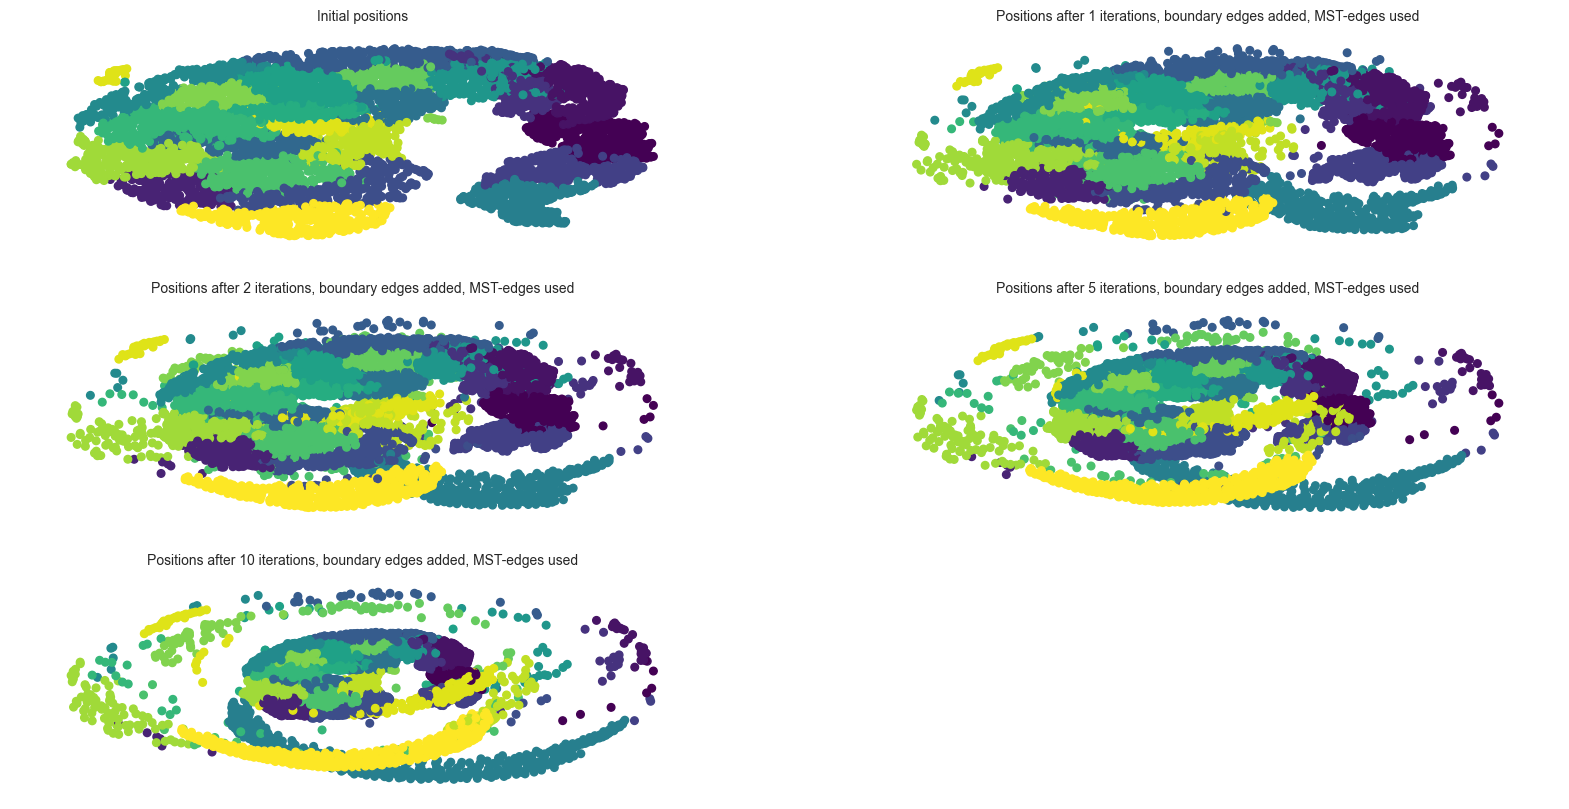

In [35]:
visualization.display_graphs(embeddings_mst_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

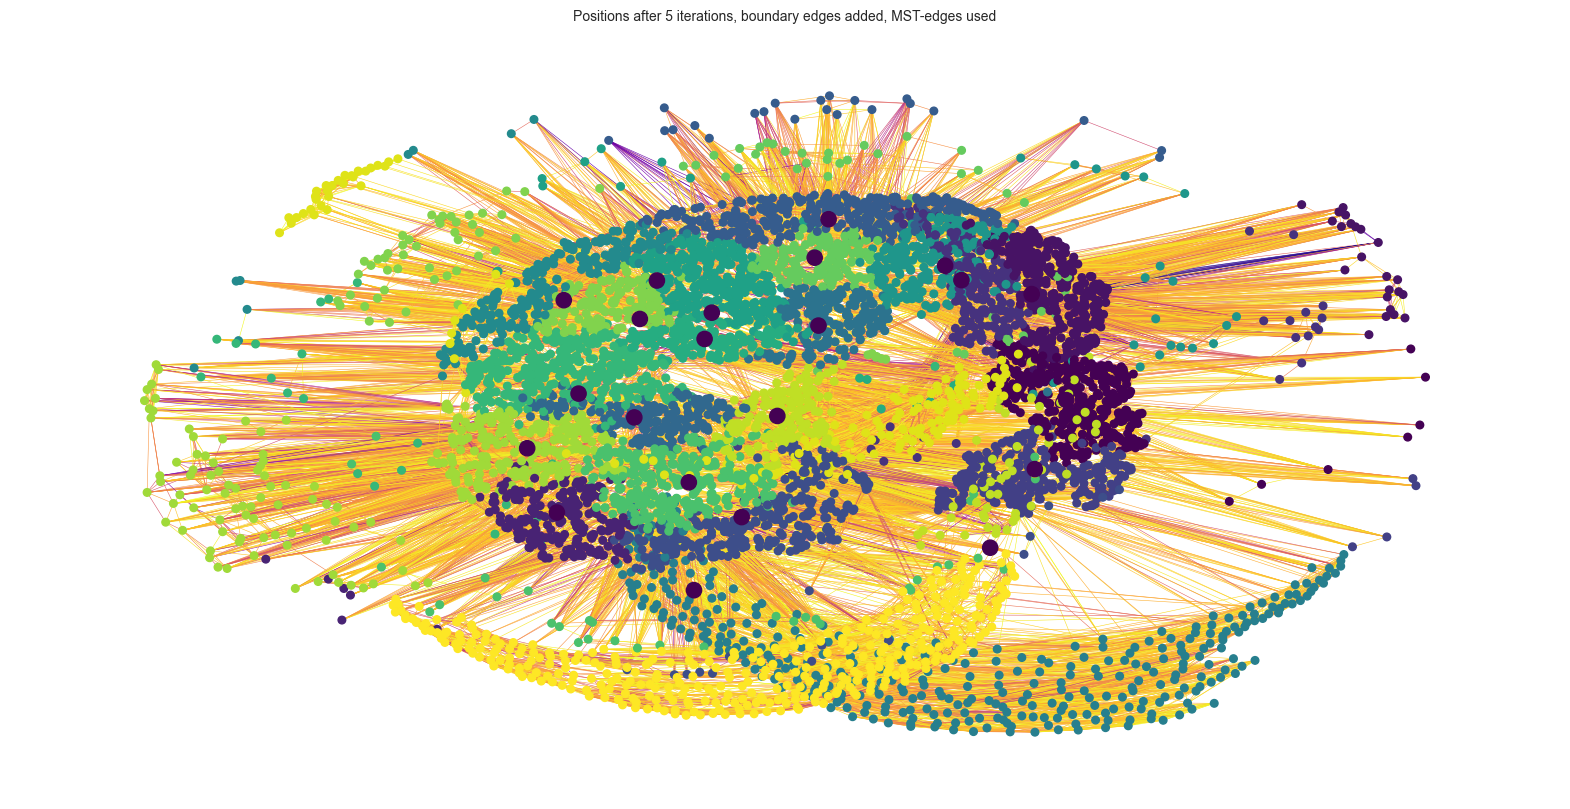

In [36]:
visualization.display_graphs([embeddings_mst_boundaries[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### Error-Search: Missing Edges

In [37]:
original_edges = set(connectivity_umap_knn_nx.edges())
result_edges = set(embeddings[1].sim_graph.edges())
print("Missing edges:", len(original_edges - result_edges))

Missing edges: 0


In [38]:
missing_graph = nx.Graph(connectivity_umap_knn_nx)
missing_graph.clear_edges()

missing_edges = original_edges - result_edges
missing_graph.add_edges_from(missing_edges)

In [39]:
doppelte = []

for u, v in connectivity_umap_knn_nx.edges():
    if connectivity_umap_knn_nx.has_edge(v, u) and connectivity_umap_knn_nx.has_edge(u,
                                                                                     v):
        doppelte.append((u, v))

print(len(doppelte))

55888


D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


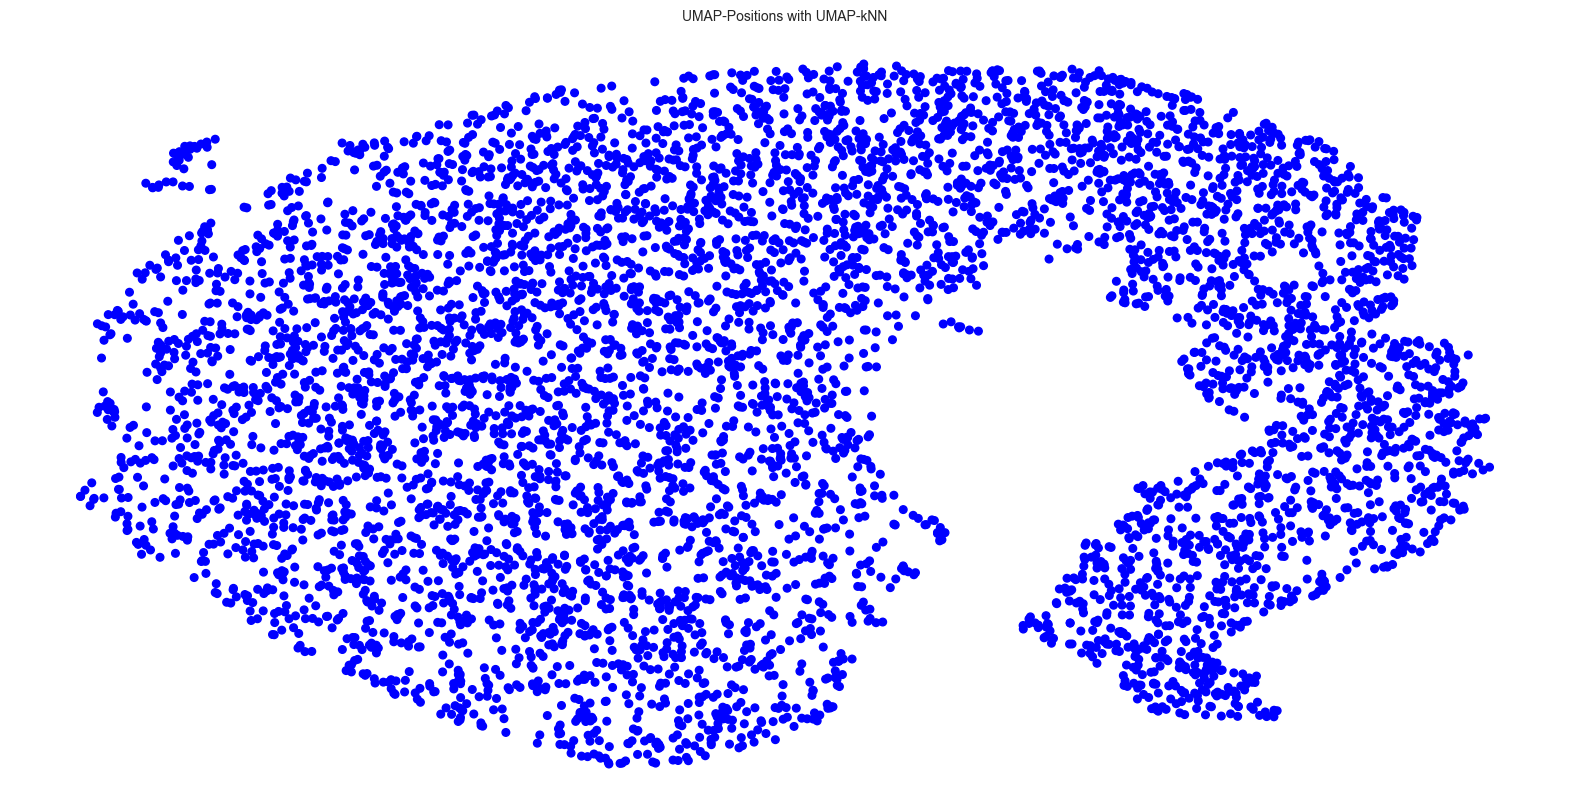

In [40]:
import numpy as np

visualization.display_graphs(
    [EmbeddingObj(graph=missing_graph, embedding=umap_embedding,
                  edge_weights=np.ndarray([0]),
                  title="UMAP-Positions with UMAP-kNN")],
    figsize_columns=1,
    figsize=(20, 10),
    show_edges=True,
    cmap='viridis',
    # cbar_labels=partition_values,
    show_cbar=False)